<a href="https://colab.research.google.com/github/rraulison/b3/blob/main/raspagem_bovespa_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Script para raspagem do site da b3 obtendo o retorno dos índices (IBOV, IBRX, IBRA, SMALL, etc)

In [ ]:
#esse metodo de instalar o chromdriver nao funciona mais desde a atualizacao do ubuntu do colab em 2023
#!pip install -q selenium
#!apt-get -q update
#!apt install -q chromium-chromedriver

#Instalacao do chromedriver (solucao temporaria)

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

In [ ]:
import pandas as pd
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import calendar
import time

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd_chrome = webdriver.Chrome(options=chrome_options)

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

#lista de url a ser passada na celula abaixo com o respectivo ano de inicio (se for passado um link com data de inicio errada vai dar erro)

IBOV (1998~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-estatisticas-historicas.htm

IBRX 100 (1998~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-brasil-100-ibrx-100-estatisticas-historicas.htm

IBRX 50 (1998~)= https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-brasil-50-ibrx-50-estatisticas-historicas.htm

IBRA (2006~)= https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-brasil-amplo-ibra-estatisticas-historicas.htm

SMLL (2006~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-small-cap-smll-estatisticas-historicas.htm

IFIX (2011~)= https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-fundos-de-investimentos-imobiliarios-ifix-estatisticas-historicas.htm

IEEX (1998~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-energia-eletrica-iee-estatisticas-historicas.htm

IDIV (2006~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-dividendos-idiv-estatisticas-historicas.htm

IVBX2 (2000~) = https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-valor-2-linha-ivbx-2-estatisticas-historicas.htm

In [ ]:
#Baixa todos os arquivos a partir de 1998 a 2023 e renomeia para '1998.csv'
url = 'https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-brasil-100-ibrx-100-estatisticas-historicas.htm'
wd_chrome.get(url)
iframe = wd_chrome.find_element(By.ID, value= "bvmf_iframe")    
wd_chrome.switch_to.frame(iframe)

for i in range(2000,2024): #ano de inicio e fim (atencao para a lista acima com o inicio de ano de cada indice)

  WebDriverWait(wd_chrome, 5).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="selectYear"]'))).send_keys(f'{i}')
  wd_chrome.switch_to.active_element
  WebDriverWait(wd_chrome, 5).until(EC.element_to_be_clickable((By.LINK_TEXT, 'Download (ano selecionado)')))
  down = wd_chrome.find_element(By.LINK_TEXT, value='Download (ano selecionado)')
  
  wd_chrome.execute_script("arguments[0].click();", down)
  time.sleep(2)
  while not os.path.isfile('/content/Evolucao_Diaria.csv'):
    if os.stat('/content/Evolucao_Diaria.csv').st_size == 0:
      time.sleep(2)
    time.sleep(0.2)
  os.rename('Evolucao_Diaria.csv', f'{i}.csv')

In [ ]:
#cria uma lista com os nomes dos arquivos para iterar
arquivo = !ls -1t *.csv
arquivo = arquivo.sort()

In [ ]:
lista = []

#itera sobre a lista de arquivos e junta todos em um dataframe
(se algum erro ocorre aqui é devido a algum ano o arquivo esta em branco e precisa ser baixado novamente)

renomeie o nome da coluna com o nome do indice na linha 5: value_name='ibrx'

In [ ]:
#itera em cada arquivo csv transformando a data para o formato datetime pandas
for i in arquivo:
  df = pd.read_csv(i, sep=';', encoding='ISO-8859-1', skipfooter=2, engine='python', thousands='.', decimal=',', header=1, index_col=False)
  df.columns = calendar.month_name[0:13]
  df1 = df.melt('', var_name='Date', value_name='ibrx')
  df1 = df1.dropna()
  df1.index = pd.to_datetime(i.rstrip('.csv') + df1.Date + df1.pop('').astype(str), format='%Y%B%d', errors='coerce')
  df1 = df1.drop(columns=['Date'])
  lista.append(df1)

#nomeie a variavel com o nome do indice

In [ ]:
ibrx = pd.concat(lista)

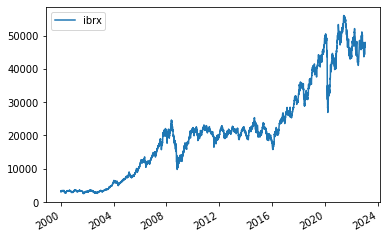

In [ ]:
ibrx.plot()

#Crie uma lista com os indices baixados 

In [ ]:
baixados = [ibov, ibrx, ibrx50, ibra, smll, ifix, ieex, idiv, ivbx2]

#remove os arquivos do diretorio para baixar outro indice

In [ ]:
for i in arquivo:
  os.remove(i)

#junta todos os indices baixados

In [ ]:
indices = pd.concat(baixados, axis=1)

#salva os indices baixados no seu google drive

In [ ]:
pd.to_pickle(indices, '/content/drive/MyDrive/Colab Notebooks/dataset/indices.pkl')

In [ ]:
indices